# Part I: Analysis

In [1]:
# Data analysis and wrangling
import pandas as pd  
import numpy as np 
from scipy.stats import chi2_contingency, pearsonr, ttest_ind
from itertools import combinations
import statsmodels.api as sm

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib 
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
url = 'https://raw.githubusercontent.com/akhullar001/triad-challenge/master/input/test_data.tsv'
student_data = pd.read_csv(url, sep='\t')

The dataset contains 11 features and 5,000 observations. The 11 features include 3 categorical features (sex, language, country), 2 continuous features (age, hours_studied) and 3 binary features (dojo_class, test_prep, pass). Three additional features include first name, last name and notes. The name of a student should not affect whether they pass the test and the notes column is mostly blank with random information for some entries.

In [3]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
sex              5000 non-null object
lang             5000 non-null object
country          5000 non-null object
age              5000 non-null int64
first            5000 non-null object
last             5000 non-null object
hours_studied    2990 non-null float64
dojo_class       5000 non-null bool
test_prep        5000 non-null bool
pass             5000 non-null bool
notes            823 non-null object
dtypes: bool(3), float64(1), int64(1), object(6)
memory usage: 327.3+ KB


In [4]:
student_data.describe()

,age,hours_studied
count,5000.000000,2990.000000
mean,25.929400,5.019735
std,7.304265,3.236989
min,18.000000,0.054288
25%,20.000000,2.619695
50%,24.000000,4.382517
75%,30.000000,6.609386
max,50.000000,28.825974


In [5]:
student_data.describe(include='O')

,sex,lang,country,first,last,notes
count,5000,5000,5000,5000,5000,823
unique,2,6,10,1193,914,397
top,Male,Japanese,Japan,Shirou,Abe,œ∑´®†¥¨ˆøπ“‘
freq,3739,3997,3997,27,86,6


In [6]:
student_data['notes'][student_data['notes'].notnull()].tail()

4956    <a href="\x0Bjavascript:javascript:alert(1)" i...
4957                                                    _
4963                                              𠜎𠜱𠝹𠱓𠱸𠲖𠳏
4977         <img\x13src=x onerror="javascript:alert(1)">
4997    `"'><img src=xxx:x \x09onerror=javascript:aler...
Name: notes, dtype: object

## Demographic Relationships

The demographic details that could be used to explain which students are most likely to pass the test include sex, language, country, and age. After transforming binary features into integers (i.e., 0 for false, 1 for true) and the categorical variables into dummy variables, I examined the Pearson correlation between the demographic features and whether a student passed the test. The feature with the highest correlation was sex, followed by age and Mexico. However, all of the correlations were very low, indicating that there is not a strong relationship between any of the demographic features and whether a student passed the test. Further, based on the p-values for the correlation coefficients, only the correlation between pass and sex and pass and age were deemed statistically significant at a confidence level of 95%. 

In [7]:
# Map categorical and boolean features to integers
student_data['sex'] = student_data['sex'].map({'Male': 1, 'Female': 0})
student_data_dummies = pd.get_dummies(student_data[['age', 'country', 'lang', 'sex', 'pass']], prefix='', prefix_sep='')

In [8]:
# Calculate correlation between features and pass 
features = student_data_dummies.columns
corr = [pearsonr(student_data_dummies[feature], student_data_dummies['pass']) for feature in features]
corr = pd.DataFrame(corr).rename(columns=({0: 'corr', 1: 'p-val'}))
corr['feature'] = features
corr['p-val'] = round(corr['p-val'], 4)
corr = corr.sort_values(by='corr', ascending=False).loc[1:,]
corr

,corr,p-val,feature
1,0.187331,0.0000,sex
0,0.059391,0.0000,age
8,0.022446,0.1125,Mexico
3,0.021674,0.1254,Australia
4,0.017581,0.2139,Finland
14,0.017581,0.2139,Finnish
13,0.014263,0.3133,English
18,0.006092,0.6667,Spanish
12,0.005070,0.7200,USA
9,0.002653,0.8512,New Zealand


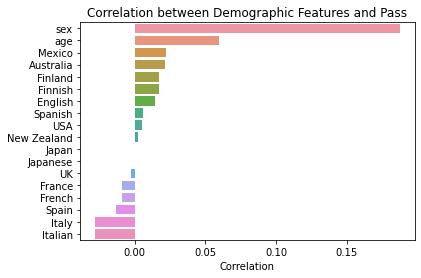

In [9]:
ax = sns.barplot(x='corr', y='feature', data=corr)
ax.set(xlabel='Correlation', ylabel='', title='Correlation between Demographic Features and Pass')
plt.show()

### Sex

Males constitute approximately 75% of the dataset. When calculating the correlation between `sex` and `pass`, males were coded as 1 and females were coded as 0. Therefore, the positive correlation between sex and pass indicates that males are more likely to pass the test than females. Indeed, examing the pass rate by sex shows that a higher percentage of males (82.5%) pass the test than females (64.7%). 

In order to ensure that the difference in pass rates between males and females is statistically significant, a chi-square test of independence was performed. The chi-square statistic was 174.42 with a p-value of 7.99e-40. Based on the p-value, the difference in pass rates is statistically significant at a 95% confidence level.

In [10]:
# Calculate breakdown of data by sex
sex_df = student_data['sex'].value_counts(normalize=True).reset_index().rename(columns={'index': 'Sex', 'sex': 'Percent'})
sex_df

,Sex,Percent
0,1,0.7478
1,0,0.2522


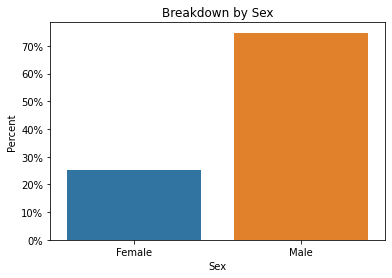

In [11]:
ax = sns.barplot(x='Sex', y='Percent', data=sex_df)
ax.set(title='Breakdown by Sex',xticklabels=['Female', 'Male'])
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

In [12]:
# Calculate breakdown of pass rates by sex
pd.crosstab(student_data['sex'], student_data['pass'], normalize='index')

pass,False,True
sex,,
0,0.352895,0.647105
1,0.174378,0.825622


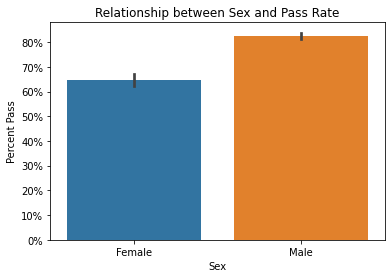

In [13]:
g = sns.barplot(x='sex', y='pass', data=student_data)
g.set(xlabel='Sex', ylabel='Percent Pass', title='Relationship between Sex and Pass Rate', xticklabels=['Female', 'Male'])
g.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

### Country

Japan is the most prevalent country in the dataset, followed by Italy and France.

In [14]:
# Calculate breakdown of data by country
country_df = student_data['country'].value_counts(normalize=True).reset_index().rename(columns={'index': 'Country', 'country': 'Percent'})
country_df

,Country,Percent
0,Japan,0.7994
1,Italy,0.0358
2,France,0.0308
3,Australia,0.0256
4,New Zealand,0.0254
5,USA,0.0252
6,UK,0.0230
7,Spain,0.0144
8,Mexico,0.0130
9,Finland,0.0074


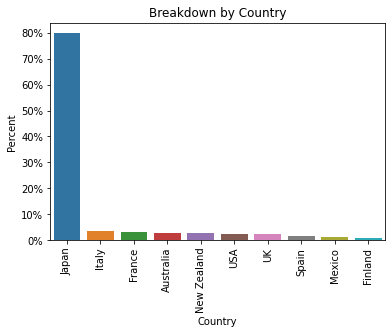

In [15]:
ax = sns.barplot(x='Country', y='Percent', data=country_df)
ax.set(title='Breakdown by Country')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=90)
plt.savefig('/Users/ankushkhullar/Desktop/TRIAD/figures/breakdown_country.png', dpi=600, bbox_inches="tight")

Pass rates by country range from 72.1% for Italy to 86.4% for Finland. Countries with the highest pass rates were Finland, Mexico and Australia and countries with the lowest pass rates were Italy, Spain, and France. While this seems to indicate that there is a relationship between where a student is from and whether he or she passes the test, the low correlations between pass and the dummy encoded country features indicates that there is a very weak relationship, if any.

A chi-square test of independence was performed to determine if the differences in pass rates between countries are statistically significant. The chi-square statistic was 11.48 with a p-value of 0.2445. The high p-value indicates that the differences are not statistically significant at a confidence level of 95%. 

It may be surprising that a 14% difference in pass rates between students from Italy and students from Finland is not significant. The reason this is the case is because of the small sample sizes for those countries. Small sample sizes translate to high standard errors. Therefore, although the difference between pass rates may seem large, the high standard errors mean that they cannot be deemed significant. 

In [16]:
# Calculate pass rates by country
order = student_data[['country', 'pass']].groupby(['country']).mean().sort_values('pass', ascending=False)
country_order = order.index
order

,pass
country,
Finland,0.864865
Mexico,0.861538
Australia,0.835938
USA,0.793651
New Zealand,0.787402
Japan,0.780585
UK,0.773913
France,0.759740
Spain,0.736111


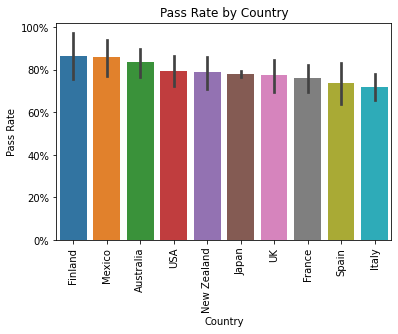

In [17]:
g = sns.barplot(x='country', y='pass', data=student_data, order=country_order)
g.set(xlabel="Country", ylabel='Pass Rate', title='Pass Rate by Country')
g.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=90)
plt.show()

In [18]:
# Chi-square test for pass rates across countries
chi2_contingency(pd.crosstab(student_data['country'], student_data['pass']))

(11.475812318722772, 0.2444979813527436, 9, array([[  28.0832,   99.9168],
        [   8.1178,   28.8822],
        [  33.7876,  120.2124],
        [  39.2726,  139.7274],
        [ 876.9418, 3120.0582],
        [  14.261 ,   50.739 ],
        [  27.8638,   99.1362],
        [  15.7968,   56.2032],
        [  25.231 ,   89.769 ],
        [  27.6444,   98.3556]]))

### Language

Given that Japan was the most represented country in the dataset, it is unsurprising that Japanese is the most prevalent language, followed by English and Italian.

In [19]:
# Calculate breakdown of data by language
language_df = student_data['lang'].value_counts(normalize=True).reset_index().rename(columns={'index': 'Language', 'lang': 'Percent'})
language_df

,Language,Percent
0,Japanese,0.7994
1,English,0.0992
2,Italian,0.0358
3,French,0.0308
4,Spanish,0.0274
5,Finnish,0.0074


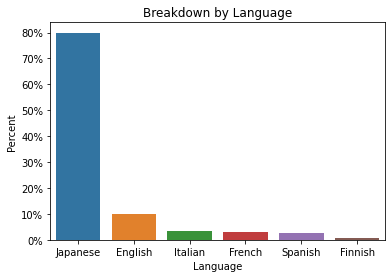

In [20]:
ax = sns.barplot(x='Language', y='Percent', data=language_df)
ax.set(title='Breakdown by Language')
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

Pass rates by language range from 72.1% for Italian to 86.5% for Finnish. Languages with the highest pass rates were Finnish, English and Spanish. Languages with the lowest pass rates were Italian, French, and Japanese. This is similar to the results of ranking countries by pass rate, which showed that students from Finland had the highest pass rate, followed by students from Mexico and Australia. However, an interesting thing to note is that the order of the top three countries does not exactly match the order of the top three languages. Whereas Mexico was the country with the second highest pass rate, Spanish, the langauge spoken in Mexico, had the third highest pass rate and whereas Australia was the country with the third highest pass rate, English, the language spoken in Austrlia, had the second highest pass rate. The reason the languages switched places is because Spanish and English are spoken in multiple countries. Namely, Spanish is also spoken in Spain, which had the second lowest pass rate. Aggregating the results for Mexico and Spain resulted in the swap between English and Spanish in the top three languages. 

While the range of pass rates seems to indicate that there is a relationship between the language a student speaks and whether he or she passes the test, the low correlations between pass and the dummy encoded language features indicates this is not the case. A chi-square test of independence for pass rates across languages provides corroboration. The chi-square statistic was 6.78 with a p-value of 0.2379. The high p-value indicates that the differences in pass rates across languages is not statistically significant at a confidence level of 95%. Again, this is due to the low representation of languages other than Japanese in the dataset.  

In [21]:
# Calculate pass rates by language
language_pass = student_data[['lang', 'pass']].groupby('lang', as_index=False).mean().sort_values(by='pass', ascending=False)
language_pass

,lang,pass
1,Finnish,0.864865
0,English,0.798387
5,Spanish,0.795620
4,Japanese,0.780585
2,French,0.759740
3,Italian,0.720670


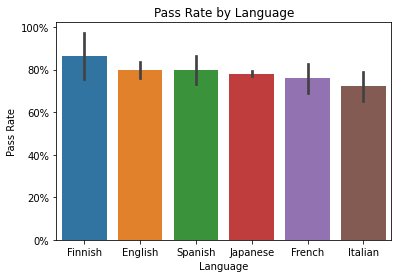

In [22]:
order = student_data[['lang', 'pass']].groupby(['lang']).mean().sort_values('pass', ascending=False)
lang_order = order.index
g = sns.barplot(x='lang', y='pass', data=student_data, order=lang_order)
g.set(xlabel="Language", ylabel='Pass Rate', title='Pass Rate by Language')
g.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.savefig('/Users/ankushkhullar/Desktop/TRIAD/figures/lang_pass_rate.png', dpi=600, bbox_inches="tight")

In [23]:
# Chi-square test for pass rates by language
chi2_contingency(pd.crosstab(student_data['lang'], student_data['pass']))

(6.775836946277368, 0.23785249330855412, 5, array([[ 108.8224,  387.1776],
        [   8.1178,   28.8822],
        [  33.7876,  120.2124],
        [  39.2726,  139.7274],
        [ 876.9418, 3120.0582],
        [  30.0578,  106.9422]]))

### Age

The final piece of demographic information that can be used to predict whether a student passes the test is age. The distribution of age has positive skew with a median value of 24. 

In [24]:
# Distribution of age 
student_data['age'].describe()

count    5000.000000
mean       25.929400
std         7.304265
min        18.000000
25%        20.000000
50%        24.000000
75%        30.000000
max        50.000000
Name: age, dtype: float64

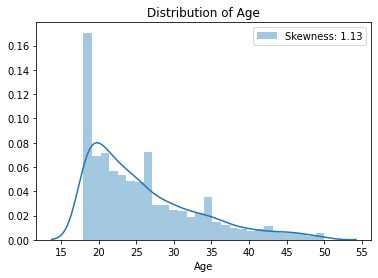

In [25]:
g = sns.distplot(student_data['age'], label='Skewness: %.2f'%(student_data['age'].skew()))
g.set(xlabel='Age', title='Distribution of Age')
plt.legend()
plt.savefig('/Users/ankushkhullar/Desktop/TRIAD/figures/age_distribution.png', dpi=600, bbox_inches="tight")

The average age of students that pass the test is 25.1, while the average age of students that fail test is 26.2. A two-sample t-test was performed to determine if the average age of students that passed the test is significantly different from the average age students that failed. The t-statistic was 4.21 with a p-value of 2.64e-5. The low p-value indicates that the difference is significant at a 95% confidence level, providing evidence that age is positive correlated with pass rates.  

In [26]:
np.mean(student_data.loc[student_data['pass'] == 0, 'age'])

25.111212397447584

In [27]:
np.mean(student_data.loc[student_data['pass'] == 1, 'age'])

26.159364591339994

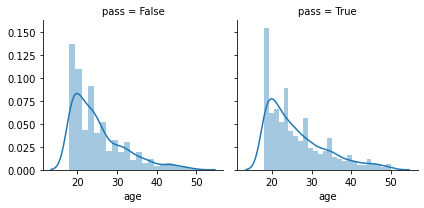

In [28]:
g = sns.FacetGrid(student_data, col='pass')
g.map(sns.distplot, 'age')
plt.show()

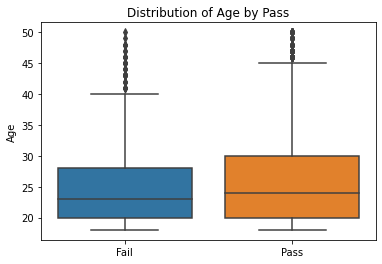

In [29]:
g = sns.boxplot(x='pass', y='age', data=student_data)
g.set(xlabel='', ylabel='Age', title='Distribution of Age by Pass', xticklabels=['Fail', 'Pass'])
plt.savefig('/Users/ankushkhullar/Desktop/TRIAD/figures/age_pass_rate.png', dpi=600, bbox_inches="tight")

In [30]:
# T-test for average age by pass 
ttest_ind(student_data.loc[student_data['pass'] == 1, 'age'], 
          student_data.loc[student_data['pass'] == 0, 'age'])

Ttest_indResult(statistic=4.206193837069958, pvalue=2.642534181097218e-05)

Binning age by quartile shows that 76% of students between 18 and 30 pass the test, 79% of students between 24 and 30 pass the test and 81% of students between the age of 30 and 50 pass.  A chi-square test was performed to determine if the difference in pass rates across age bands is statistically significant. The chi-square statistic was 14.00 with a p-value of 0.0029, indicating the differene in pass rates across age bands is statistically significant at a 95% confidence level. However, the test only indicates that the at least one of the age band pairs has a siginificant difference in pass rates. 

In order to determine which pairs have a siginificant difference, a post-hoc test was performed by running a chi-square test for each pair of age bands. Since tests were run repeatedly, the Bonferroni adjustment was used to correct for issues associated with multiple testing. Based on the results of the post-hoc analysis, there is a significant difference in pass rates between students under the age of 30 and students above the age of 30, with approximately 76.9% of those under 30 passing the test and 81.2% of those above 30 passing. 

In [31]:
# Split age into age bands 
student_data['age_band'] = pd.qcut(student_data['age'], q=4)

In [32]:
student_data['age_band'] = pd.qcut(student_data['age'], q=4)
pd.crosstab(student_data['age_band'], student_data['pass'], normalize='index')

pass,False,True
age_band,,
"(17.999, 20.0]",0.237226,0.762774
"(20.0, 24.0]",0.239329,0.760671
"(24.0, 30.0]",0.209664,0.790336
"(30.0, 50.0]",0.185505,0.814495


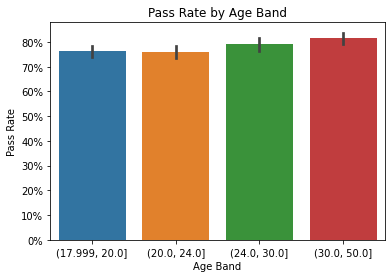

In [33]:
g = sns.barplot(x='age_band', y='pass', data=student_data)
g.set(xlabel="Age Band", ylabel='Pass Rate', title='Pass Rate by Age Band')
g.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.savefig('/Users/ankushkhullar/Desktop/TRIAD/figures/age_band_pass_rate.png', dpi=600, bbox_inches="tight")

In [34]:
# Chi-square test for pass rates across age bands 
chi2_contingency(pd.crosstab(student_data['age_band'], student_data['pass']))

(14.001114888193367, 0.0029036356134077585, 3, array([[ 300.578 , 1069.422 ],
        [ 287.8528, 1024.1472],
        [ 254.2846,  904.7154],
        [ 254.2846,  904.7154]]))

In [35]:
all_combinations = list(combinations(student_data['age_band'].unique(), 2))
p_vals = []
for comb in all_combinations:
    age_pair = student_data[(student_data['age_band'] == comb[0]) | (student_data['age_band'] == comb[1])]
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(age_pair['age_band'], age_pair['pass']))
    p_vals.append(p)
    
significant = [x < 0.05/6 for x in p_vals]
chi2_combinations = pd.DataFrame(
    {'age_pair': all_combinations, 
     'p_val': p_vals, 
     'significant': significant})
chi2_combinations

,age_pair,p_val,significant
0,"((30.0, 50.0], (17.999, 20.0])",0.001847,True
1,"((30.0, 50.0], (24.0, 30.0])",0.159008,False
2,"((30.0, 50.0], (20.0, 24.0])",0.001346,True
3,"((17.999, 20.0], (24.0, 30.0])",0.108024,False
4,"((17.999, 20.0], (20.0, 24.0])",0.934283,False
5,"((24.0, 30.0], (20.0, 24.0])",0.086724,False


In [36]:
ttest_ind(student_data.loc[student_data['sex'] == 1, 'age'], 
          student_data.loc[student_data['sex'] == 0, 'age'])

Ttest_indResult(statistic=0.10241309645486012, pvalue=0.9184328973525433)

### Summary 

Based on the analysis of the relationship between demographic factors and pass rate, the following conclusions can be made: 

1. **Sex** - males are more likely to pass the test than females; 
2. **Country** - no significant relationship between country and pass rate; 
3. **Language** - no significant relationship between language and pass rate; and,
4. **Age** - postive relationship between age and pass rate; further analysis showed that students over the age of 30 are more likely to pass the exam than students under the age of 30. 

## Intervention Efficacy

The dataset contains binary features, `dojo_class` and `test_prep`, representing interventions intended to increase the chances of a student passing the test. The overall distribution of these features shows that approximately 30% of students participated in the Dojo class and 21% participated in the test prep course.  

The correlation between students who took the Dojo class and students that passed the test is 0.1637, while the correlation between students who took the test prep course and students that passed the test is only 0.0163. Based on this information, it appears that students who take the Dojo class are slightly more likely to pass the test. On the other hand, there does not seem to be any relationship between students who took the test prep course and whether they passed the test.

In [37]:
# Calculate distributions of students who took the classes 
student_data['dojo_class'].value_counts(normalize=True)

False    0.6956
True     0.3044
Name: dojo_class, dtype: float64

In [38]:
student_data['test_prep'].value_counts(normalize=True)

False    0.7906
True     0.2094
Name: test_prep, dtype: float64

In [39]:
student_data[['dojo_class', 'test_prep', 'pass']].corr()['pass']

dojo_class    0.162713
test_prep     0.016286
pass          1.000000
Name: pass, dtype: float64

### Dojo Class

Approximately 88% of students who took the Dojo class passed the test, while only 74% of students who did not take the Dojo class passed. A chi-square test examining the relationship between `dojo_class` and `pass` resulted in a chi-square statistic of 131.52 with a p-value of 1.90e-30. The low p-value indicates that the difference in pass rates between students who take the Dojo class and students who do not take the Dojo class is statistically significant at a 95% confidence level. 

In [40]:
# Calculate pass rates for students who took the Dojo class
pd.crosstab(student_data['dojo_class'], student_data['pass'], normalize='index')

pass,False,True
dojo_class,,
False,0.263945,0.736055
True,0.117608,0.882392


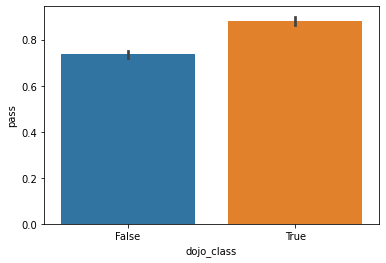

In [41]:
sns.barplot(x='dojo_class', y='pass', data=student_data)

In [42]:
# Chi-square test for pass rates between dojo_class
chi2_contingency(pd.crosstab(student_data['dojo_class'], student_data['pass']))

(131.52428465795086, 1.9013412729235812e-30, 1, array([[ 763.0732, 2714.9268],
        [ 333.9268, 1188.0732]]))

As it was determined in the previous section that sex and age are related to pass rate, we must ensure that the effect from `dojo_class` are independent of the effects from the demographic features. That is, we must ensure that the higher pass rate for students who took the class is not because more males take the class than females or because students who take the classs are, on average, older than students who do not take the class. 

The distribution of males and females who took the Dojo class is representative of the sample as a whole. That is, appriximately 75% of the students who took the class are male and approximately 75% of students who did not take the class are also male. Furthermore, a two sample t-test examining the relationship between the `age` and `dojo_class` resulted in a t-statistic of 1.00 with p-value of 0.3158, indicating that there is not a statistically significant difference in the average age of students who took the class and students who did not take the class. Therefore, we can conclude that taking the Dojo class increases the chances of passing the test. 

In [43]:
pd.crosstab(student_data['dojo_class'], student_data['sex'], normalize='index')

sex,0,1
dojo_class,,
False,0.255319,0.744681
True,0.245072,0.754928


In [44]:
chi2_contingency(pd.crosstab(student_data['dojo_class'], student_data['sex']))

(0.5363418007128696, 0.4639527695685288, 1, array([[ 877.1516, 2600.8484],
        [ 383.8484, 1138.1516]]))

In [45]:
ttest_ind(student_data.loc[student_data['dojo_class'] == 1, 'age'], 
          student_data.loc[student_data['dojo_class'] == 0, 'age'])

Ttest_indResult(statistic=1.00332079688192, pvalue=0.31575467656013273)

### Test Prep

Approximately 79% of students who took the test prep class passed the test and 78% of students who did not take the test prep class passed. A chi-square test examining the relationship between `test_prep` and `pass` resulted in a chi-square statistic of 1.23 with a p-value of 0.2672. The p-value indicates that the difference in pass rates between students who take the test prep class and students who do not take the test prep class is not statistically significant at a 95% confidence level. This is in line with the very low correlation between students who took the test prep course and students that passed the tes. Therefore, we can conclude that the test prep course does not increase the likelihood of a student passing the test. 

In [46]:
# Calculate pass rates for students who took the test prep class 
pd.crosstab(student_data['test_prep'], student_data['pass'], normalize='index')

pass,False,True
test_prep,,
False,0.222869,0.777131
True,0.206304,0.793696


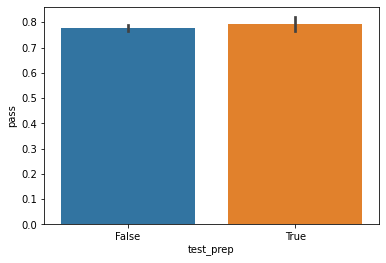

In [47]:
sns.barplot(x='test_prep', y='pass', data=student_data)

In [48]:
# Chi-square test for pass rates between dojo_class
chi2_contingency(pd.crosstab(student_data['test_prep'], student_data['pass']))

(1.2312757314759601, 0.2671590820740462, 1, array([[ 867.2882, 3085.7118],
        [ 229.7118,  817.2882]]))

### Conclusion

Based on the analysis of interventions, the following can be concluded: 
    
1. Students who take the Dojo class are more likely to pass the test; and,
2. There is no relationship between students who take the test prep course and students who pass the test. 

## Further Analysis

One final variable that is likely to be related to whether a student passes the test is hours studied. 

### Hours Studied 

One difficulty with hours studied is that appriximately 40% of the 5,000 observations are missing values for the `hours_studied`. Nonetheless, we can use the data that is avaialble to determine if there is a relationship between hours studied and whether a student passes the test. 

The distribution of hours studied that are avaialble in the dataset has positive skew with a median value of 4.38 hours. The median number of hours studied by students who pass the test is 4.6 hours, while the median of hours studied by students who fail the test is 3.8 hours. This indicates that hours studied has a positive relationship with pass. 

A two-sample t-test was performed to determine if the average age of students that passed the test is significantly different from the average age students that failed. The t-statistic was 5.77 with a p-value of 2.34e-9. The low p-value indicates that the difference is significant at a 95% confidence level, providing evidence that hours studied is positive correlated with whether a student passes the test. 

In [49]:
# Examine distribution of hours_studied
student_data['hours_studied'].describe()

count    2990.000000
mean        5.019735
std         3.236989
min         0.054288
25%         2.619695
50%         4.382517
75%         6.609386
max        28.825974
Name: hours_studied, dtype: float64

In [50]:
student_clean = student_data.drop(['first', 'last', 'notes'], axis=1)
student_clean = student_clean.dropna().reset_index(drop=True)

In [51]:
student_clean[['hours_studied', 'age', 'pass']].corr()

,hours_studied,age,pass
hours_studied,1.000000,0.024516,0.105118
age,0.024516,1.000000,0.066576
pass,0.105118,0.066576,1.000000


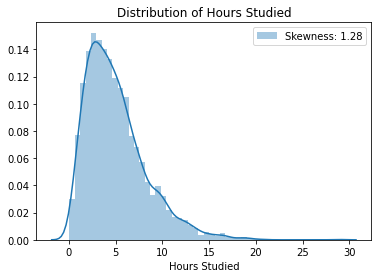

In [52]:
g = sns.distplot(student_clean['hours_studied'], label='Skewness: %.2f'%(student_data['hours_studied'].skew()))
g.set(xlabel='Hours Studied', title='Distribution of Hours Studied')
plt.legend()
plt.savefig('/Users/ankushkhullar/Desktop/TRIAD/figures/hours_studied_distribution.png', dpi=600, bbox_inches="tight")

In [53]:
# T-test for average age of students that passed/failed the test
ttest_ind(student_clean.loc[student_clean['pass'] == 1, 'hours_studied'], 
          student_clean.loc[student_clean['pass'] == 0, 'hours_studied'])

Ttest_indResult(statistic=5.778042810213596, pvalue=8.336067039817048e-09)

### Logistic Regression

The previous sections provided evidence that sex, age, dojo_class and hours_studied are related to whether a student passes the test, but does not assess the magnitude or importance of these features. One way to do that is to perform a logistic regression and analyse the coefficients for each feature. 

In [54]:
# Logistic regression using demographic features
student_clean[['pass', 'dojo_class']] = student_clean[['pass', 'dojo_class']].astype(int)
X = student_clean[['sex', 'age', 'dojo_class']]

X = sm.add_constant(X)
y = student_clean['pass']

In [55]:
logreg = sm.Logit(y,X)
result = logreg.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.489279
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.066     
Dependent Variable: pass             AIC:              2933.8883 
Date:               2020-05-07 15:34 BIC:              2957.9004 
No. Observations:   2990             Log-Likelihood:   -1462.9   
Df Model:           3                LL-Null:          -1566.8   
Df Residuals:       2986             LLR p-value:      9.0654e-45
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
const          -0.2835    0.1910  -1.4844  0.1377  -0.6579  0.0908
sex             0.9286    0.0967   9.6070  0.0000   0.7392  1.

In [56]:
print('Male odds: {}'.format(round(np.exp(result.params[1]), 2)))
print('Age odds: {}'.format(round(np.exp(result.params[2]), 2)))
print('Dojo class odds: {}'.format(round(np.exp(result.params[3]), 2)))

Male odds: 2.53
Age odds: 1.03
Dojo class odds: 3.04


The results of the logistic regression reveal the following: 

1.	Sex - The odds that a male will pass the test are 2.53 times higher than the odds that a female will pass;
2.	Age - A one-year increase in age increases the odds of passing the exam by 1.03; 
3.	Dojo class - The odds that a student who takes the Dojo class will pass the test are 3.04 times higher than a student who does not take the Dojo class. 

Based on these results, Dojo class had the highest impact on whether a student passes the test, followed by sex and age. It is important to note that the relative importances are based on the logistic regression analysis, including any assumptions made by a logistic regression model (e.g., linear relationship between predictors and log odds of the response). Therefore, the relative importances can be different if using a different model.  